<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')
print(df.shape[0])

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus'] #cple
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']



8750


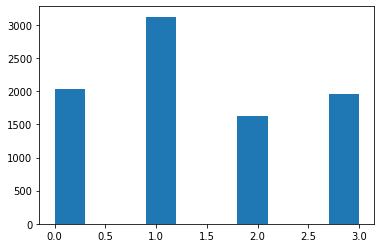

In [2]:
y_new = []
for val in y:
  if(val<10):
    y_new.append(0)
  elif(10 <= val and val <100):
    y_new.append(1)
  elif(100<=val and val<1000):
    y_new.append(2)
  else:
    y_new.append(3)

shuffled['y_new'] = y_new
#print(shuffled.head())
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
plt.hist(y_new)
plt.show()
#X_modified = X
X_modified = X.drop(['n/m', '(n/m)^2', '(n/m)^3', 'm/n', '(m/n)^2', '(m/n)^3', 'class', 'max', 'av.length'], axis = 1)
#print(X_modified.shape[1])

In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(8, input_dim = X_modified.shape[1], activation='relu'))
#classifier.add(Dense(8, activation = 'relu'))

classifier.add(Dense(16, activation = 'relu'))
#classifier.add(Dropout(0.25))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(16, activation = 'relu'))

classifier.add(Dense(8, activation = 'relu'))

classifier.add(Dense(4, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.8)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [6]:
#classifier.fit(X_train, y_train, batch_size = 64, epochs = 20, verbose = 1)
#scores = classifier.evaluate(X_test, y_test)
#for i, m in enumerate(classifier.metrics_names):
#    print("\n%s: %.3f"% (m, scores[i]))


Epoch 1/300
438/438 [==============================] - 2s 3ms/step - loss: 1.1137 - accuracy: 0.5560 - val_loss: 0.7818 - val_accuracy: 0.6783
Epoch 2/300
438/438 [==============================] - 1s 2ms/step - loss: 0.6749 - accuracy: 0.7326 - val_loss: 0.6311 - val_accuracy: 0.7309
Epoch 3/300
438/438 [==============================] - 1s 2ms/step - loss: 0.5883 - accuracy: 0.7586 - val_loss: 0.5738 - val_accuracy: 0.7629
Epoch 4/300
438/438 [==============================] - 1s 2ms/step - loss: 0.5542 - accuracy: 0.7729 - val_loss: 0.5610 - val_accuracy: 0.7783
Epoch 5/300
438/438 [==============================] - 1s 2ms/step - loss: 0.5303 - accuracy: 0.7870 - val_loss: 0.5360 - val_accuracy: 0.7823
Epoch 6/300
438/438 [==============================] - 1s 2ms/step - loss: 0.5146 - accuracy: 0.7889 - val_loss: 0.5386 - val_accuracy: 0.7851
Epoch 7/300
438/438 [==============================] - 1s 2ms/step - loss: 0.5035 - accuracy: 0.7941 - val_loss: 0.5353 - val_accuracy: 0.7789

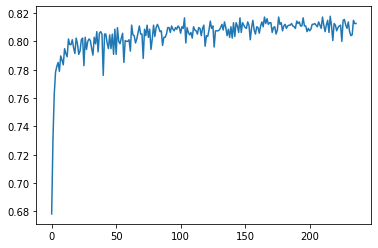

In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 16, 
                    epochs = 300, validation_data =(X_test, y_test), 
                    callbacks =[earlystopping])
plt.plot(history.history['val_accuracy'])



In [8]:
from keras.metrics import accuracy
#test_size = X_test.shape[0]
pred = classifier.predict(X_test)
#print(pred)
pred_ = np.argmax(pred, axis = 1)
#print(pred_)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])

#for i,j in zip(pred_, true_y):
#    print("Predicted: {}, True: {}".format(i, j))

cnt = 0
cnt_correct = 0

for i in range(len(pred_)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1

print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

accuracy: 81.14%


accuracy: 81.14%


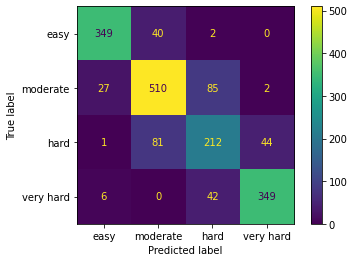

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#for i in range(len(pred_)):
#  print(true_y[i])
#print(confusion_matrix(true_y, pred_, labels=[0, 1, 2, 3]))
cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2, 3])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate', 'hard', 'very hard'])
#plt.subplot(1, 2, 1)
cmd.plot()
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

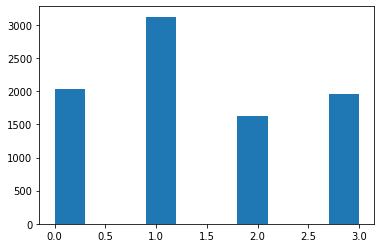

In [10]:
y_new = np.array(y_new)
plt.hist(y_new)
#plt.title('0->[0,2000) : 1->[2000,99999]')
plt.show()